In [1]:
# importere biblioteerne vi bruger i pogrammet
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
# definere preprocessoren

features = ["model", "year", "transmission", "mileage", "fuelType", "mpg", "engineSize", "brand"]

cat_features = ["model", "transmission", "fuelType", "brand"]
cont_features = ["year", "mileage", "mpg", "engineSize"]

# laver en preprocesser med to forskellige transformere
preprocessor = ColumnTransformer(
    transformers=[
        # onehot til kategoriske features
        ("cat", OneHotEncoder(), cat_features),
        # standardscaler til "continues features"(tal)
        ("cont", StandardScaler(), cont_features)
    ])

In [3]:
# indlæser datasættet og transformere med prepocessor
data = pd.read_csv("./samletdata.csv", sep=";", decimal=",")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data["model"] = data["model"].str.strip()

X = preprocessor.fit_transform(data.drop(["price", "tax"], axis=1))
# pickler prepocessoren til brug i hjemmesiden
with(open("preprocessor.pkl", "wb")) as f:
    pkl.dump(preprocessor, f)

y = data['price']

In [4]:
# laver dictionaries til at kunne laver søjlediagrammer
from statistics import mean

X_plot = data.drop(["price", "tax", "model"], axis=1)

brand_dict = {}
for brand in X_plot["brand"].unique():
    brand_dict[brand] = mean([y[i] for i, row in X_plot.iterrows() if row["brand"] == brand])
print(brand_dict)
trans_dict = {}
for trans in X_plot["transmission"].unique():
    trans_dict[trans] = mean([y[i] for i, row in X_plot.iterrows() if row["transmission"] == trans])
print(trans_dict)
fuel_dict = {}
for fuel in X_plot["fuelType"].unique():
    fuel_dict[fuel] = mean([y[i] for i, row in X_plot.iterrows() if row["fuelType"] == fuel])
print(fuel_dict)

KeyboardInterrupt: 

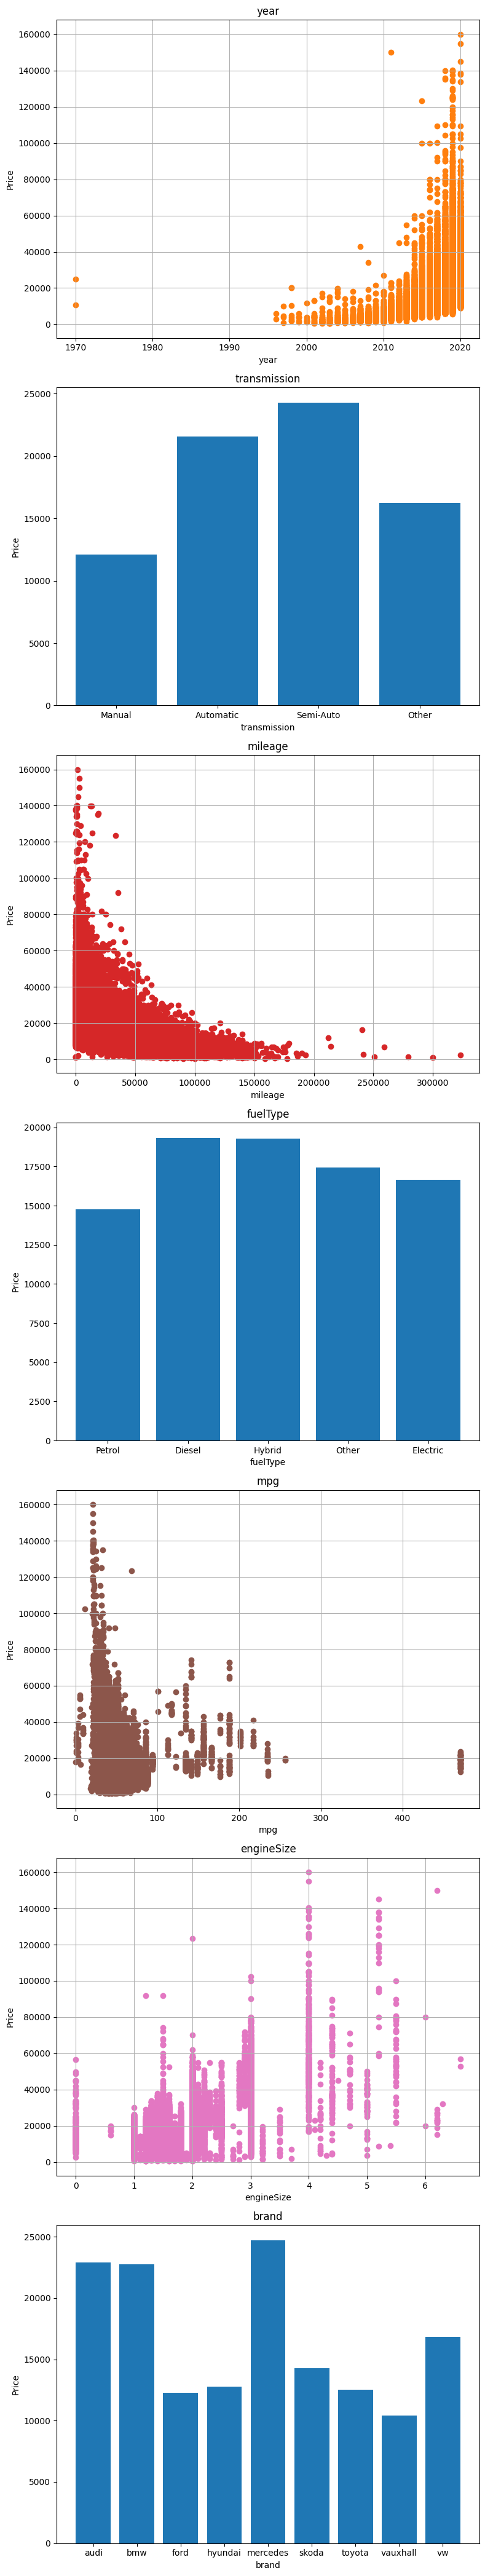

In [6]:
# plotter vores data med matplotlib
colors = {"year": "tab:orange", "transmission": "tab:green", "mileage": "tab:red", "fuelType": "tab:purple", "mpg": "tab:brown", "engineSize": "tab:pink", "brand": "tab:gray"}
plot_features = [feature for feature in features if feature != "model"]
fig, axs = plt.subplots(nrows=len(plot_features), ncols=1, figsize=(8, 6 * len(plot_features)))

# Iterate over each feature and create scatterplot
for i, col in enumerate(plot_features):
    if col in cont_features:
        axs[i].scatter(X_plot.iloc[:, i], y, c=colors[col])
        axs[i].set_title(col)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Price')
        axs[i].grid(True)
    elif col == "brand":
        axs[i].bar(brand_dict.keys(), brand_dict.values())
        axs[i].set_title(col)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Price')
    elif col == "transmission":
        axs[i].bar(trans_dict.keys(), trans_dict.values())
        axs[i].set_title(col)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Price')
    elif col == "fuelType":
        axs[i].bar(fuel_dict.keys(), fuel_dict.values())
        axs[i].set_title(col)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

In [4]:
# lav "pipeline" og fitter den til dataen
model = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=3)), # polynomiske features så modellen passer bedre til dataen
    ('regressor', LinearRegression()) # lineær regression pågrund af god perfomance
], verbose=True)

model.fit(X, y)
pkl.dump(model, open("model.pkl", "wb"))


[Pipeline] .............. (step 1 of 2) Processing poly, total=   0.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 1.9min


In [7]:
# test prediction
test_data = {col: [data] for col, data in zip(features, ["Octavia", 2010, "Manual", 118000, "Petrol", 41.2, 1.2, "skoda"])}

test_data = pd.DataFrame(test_data)
test_data = preprocessor.transform(test_data)
print(model.predict(test_data))

[4856.47692679]


In [8]:
# test R2 værdi ved at splitte X i test og træning og fitter modellen igen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print("Model R-squared (R2) Score:", score)

[Pipeline] .............. (step 1 of 2) Processing poly, total=   0.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 1.7min
Model R-squared (R2) Score: 0.9513115649825344
